In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
import math
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from scipy import stats

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
def print_nulls(df):
    
    out = df.isnull().sum()*100/df.isnull().isnull().count()
    
    pd.set_option('display.max_rows', len(out))
    print(out)
    pd.reset_option('display.max_rows')

In [3]:
def print_outliers(lower_inner_upper, df):
    
    if lower_inner_upper == 'lower':
        
        print('Continuious Variables', '\n')

        for column in df.select_dtypes(include='number'):
            print(column)
            for threshold in [95, 90, 85, 80, 75]:
                lower_bound = np.percentile(df[column], [100-threshold])[0]
                
                print('Beyond the upper {}th percentile there are {} outliers'.format(threshold, 
                    len((np.where((df[column] < lower_bound))[0]))
                ))
                
            if (df[column].nunique() < 5):
                print('\n')
                print('Possible Categorical Variable')
                print('There are {} unique values'.format(df[column].nunique()))
                print(df[column].value_counts())
            print('\n')
    
    elif lower_inner_upper == 'inner':
        
        print('Continuious Variables', '\n')
    
        for column in df.select_dtypes(include='number'):
            print(column)
            for threshold in [95, 90, 85, 80, 75]:
                alpha = 100 - threshold
                upper_bound, lower_bound = np.percentile(df[column]
                                                         , [(100 - alpha/2), (0 + alpha/2)]) 

                print("Beyond the inner {}th percentile there are {} outliers.".format(threshold,
                        len((np.where((df[column] > upper_bound) 
                                      | (df[column] < lower_bound))[0]))
                    ))

            if (df[column].nunique() < 5):
                print('\n')
                print('Possible Categorical Variable')
                print('There are {} unique values'.format(df[column].nunique()))
                print(df[column].value_counts())
            print('\n')
            
    elif lower_inner_upper == 'upper':
    
        print('Continuious Variables', '\n')

        for column in df.select_dtypes(include='number'):
            print(column)
            for threshold in [95, 90, 85, 80, 75]:
                upper_bound = np.percentile(df[column], [threshold])[0]
                
                print('Beyond the lower {}th percentile there are {} outliers'.format(threshold, 
                    len((np.where((df[column] > upper_bound))[0]))
                ))
                
            if (df[column].nunique() < 5):
                print('\n')
                print('Possible Categorical Variable')
                print('There are {} unique values'.format(df[column].nunique()))
                print(df[column].value_counts())
            print('\n')
        
        
    
    print('Categorical Variables', '\n')
    
    for column in df.select_dtypes(include='object'):
        print(column)
        print('There are {} unique values'.format(df[column].nunique()))
        print(df[column].value_counts())
        print('\n')

## Objective

To create a machine learning model that will predict the saleprice of a house based upon our data set. This is an illustrative example to demonstrate my ability to work with data and produce a viable model. The objective 
This model likely would not generalize because as we will discuss below this data set is limited to houses in a specific municipality and timeframe. In order to generalize this model we would need to retrain using more recent and relevant data.

## Load the data

This data set is the well known Houseprices data set from Kaggle and contains information about houses sold in Ames Iowa between 2006 and 2010. More information about this data set including the data dictionary can be found here: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

This data set was compiled by Dean De Cock and the original publication can be found here: http://jse.amstat.org/v19n3/decock.pdf

In [4]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

query1 = '''
SELECT
  *
FROM
  houseprices
'''

df = pd.read_sql_query(query1, con=engine)
engine.dispose()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

## Data cleaning and EDA

In [6]:
print_nulls(df)

id               0.000
mssubclass       0.000
mszoning         0.000
lotfrontage     17.740
lotarea          0.000
street           0.000
alley           93.767
lotshape         0.000
landcontour      0.000
utilities        0.000
lotconfig        0.000
landslope        0.000
neighborhood     0.000
condition1       0.000
condition2       0.000
bldgtype         0.000
housestyle       0.000
overallqual      0.000
overallcond      0.000
yearbuilt        0.000
yearremodadd     0.000
roofstyle        0.000
roofmatl         0.000
exterior1st      0.000
exterior2nd      0.000
masvnrtype       0.548
masvnrarea       0.548
exterqual        0.000
extercond        0.000
foundation       0.000
bsmtqual         2.534
bsmtcond         2.534
bsmtexposure     2.603
bsmtfintype1     2.534
bsmtfinsf1       0.000
bsmtfintype2     2.603
bsmtfinsf2       0.000
bsmtunfsf        0.000
totalbsmtsf      0.000
heating          0.000
heatingqc        0.000
centralair       0.000
electrical       0.068
firstflrsf 

In [7]:
print_nulls(df.select_dtypes(exclude='object'))

id               0.000
mssubclass       0.000
lotfrontage     17.740
lotarea          0.000
overallqual      0.000
overallcond      0.000
yearbuilt        0.000
yearremodadd     0.000
masvnrarea       0.548
bsmtfinsf1       0.000
bsmtfinsf2       0.000
bsmtunfsf        0.000
totalbsmtsf      0.000
firstflrsf       0.000
secondflrsf      0.000
lowqualfinsf     0.000
grlivarea        0.000
bsmtfullbath     0.000
bsmthalfbath     0.000
fullbath         0.000
halfbath         0.000
bedroomabvgr     0.000
kitchenabvgr     0.000
totrmsabvgrd     0.000
fireplaces       0.000
garageyrblt      5.548
garagecars       0.000
garagearea       0.000
wooddecksf       0.000
openporchsf      0.000
enclosedporch    0.000
threessnporch    0.000
screenporch      0.000
poolarea         0.000
miscval          0.000
mosold           0.000
yrsold           0.000
saleprice        0.000
dtype: float64


Most of these columns have no missing values. According to the data dictionary null values represent cases where the hosue does not have the feature in question. This makes filling nulls relativelyl straightforward.

In [8]:
# move the target variable to be the first column for convience and ease of reading outputs

df = df[['saleprice', 'id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
         'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paveddrive', 'wooddecksf', 'openporchsf',
       'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'poolqc',
       'fence', 'miscfeature', 'miscval', 'mosold', 'yrsold', 'saletype',
       'salecondition']]

In [9]:
# Combine information from some related features for dimension reduction

df['total_square_feet'] = df['totalbsmtsf'] + df['grlivarea']

df['total_full_bath'] = df['fullbath'] + df['bsmtfullbath']

df['total_half_bath'] = df['halfbath'] + df['bsmthalfbath']

# Drop the component features

df.drop(['totalbsmtsf', 'grlivarea', 'fullbath', 'bsmtfullbath', 'halfbath', 'bsmthalfbath'], axis=1, inplace=True)

In [58]:
df.corr()['saleprice'].sort_values(ascending=False)

saleprice            1.000
overallqual          0.791
total_square_feet    0.779
garagecars           0.640
garagearea           0.623
firstflrsf           0.606
total_full_bath      0.583
totrmsabvgrd         0.534
yearbuilt            0.523
yearremodadd         0.507
garageyrblt          0.486
masvnrarea           0.477
fireplaces           0.467
bsmtfinsf1           0.386
lotfrontage          0.352
wooddecksf           0.324
secondflrsf          0.319
openporchsf          0.316
lotarea              0.264
total_half_bath      0.251
bsmtunfsf            0.214
bedroomabvgr         0.168
screenporch          0.111
poolarea             0.092
mosold               0.046
threessnporch        0.045
bsmtfinsf2          -0.011
miscval             -0.021
id                  -0.022
lowqualfinsf        -0.026
yrsold              -0.029
overallcond         -0.078
mssubclass          -0.084
enclosedporch       -0.129
kitchenabvgr        -0.136
Name: saleprice, dtype: float64

In [11]:
# Drop some of the weakly correlated features to narrow the focus for the first iteration of the model

df_reduced = df[['saleprice', 'overallqual', 'total_square_feet', 'total_full_bath', 'garagearea', 'garagecars']]

In [12]:
corr_map = df_reduced.corr()

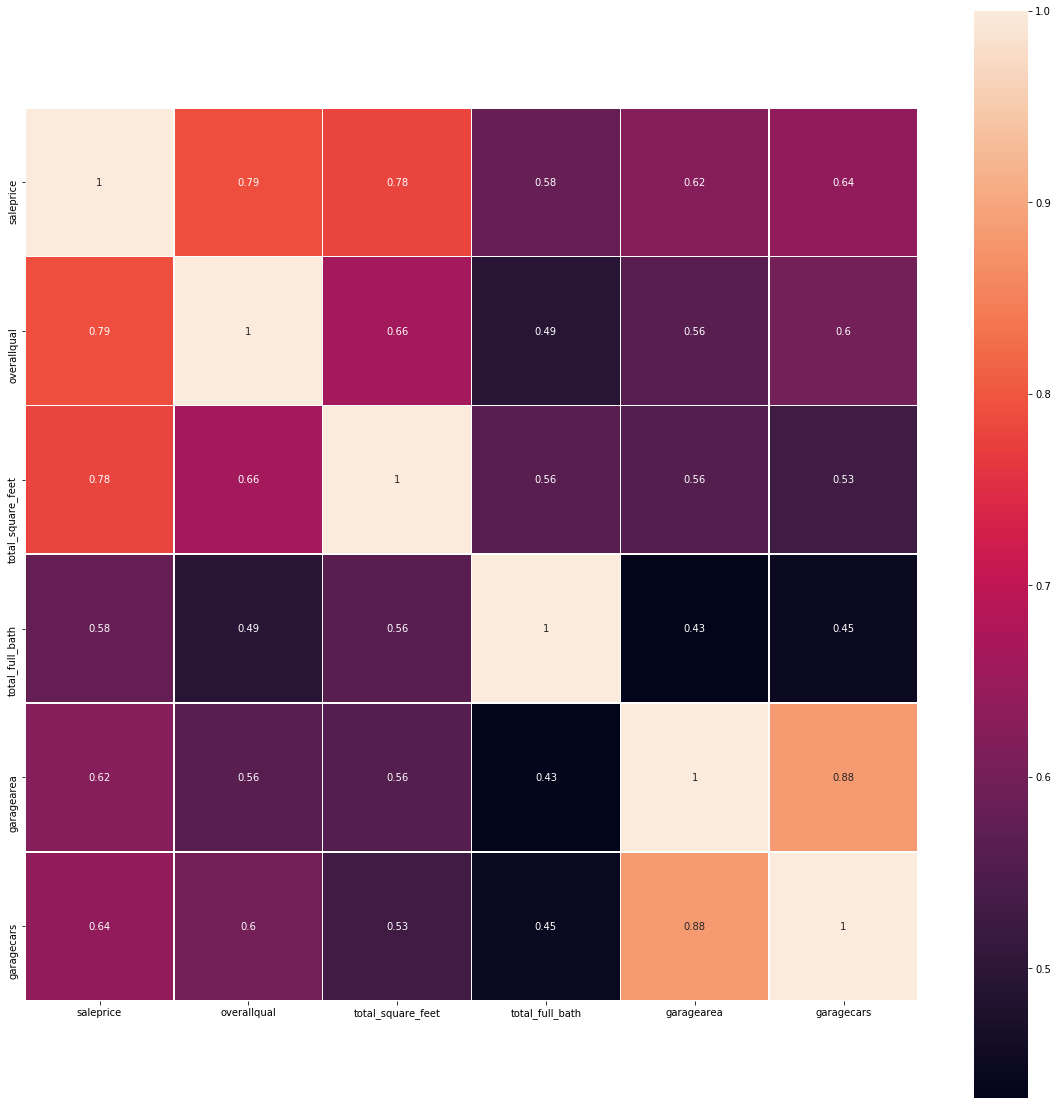

In [13]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_map, square=True, annot=True, linewidths=.5,)
plt.show()

Visualize the variance of categorical features.

In [14]:
cats = df.select_dtypes(include='object').columns

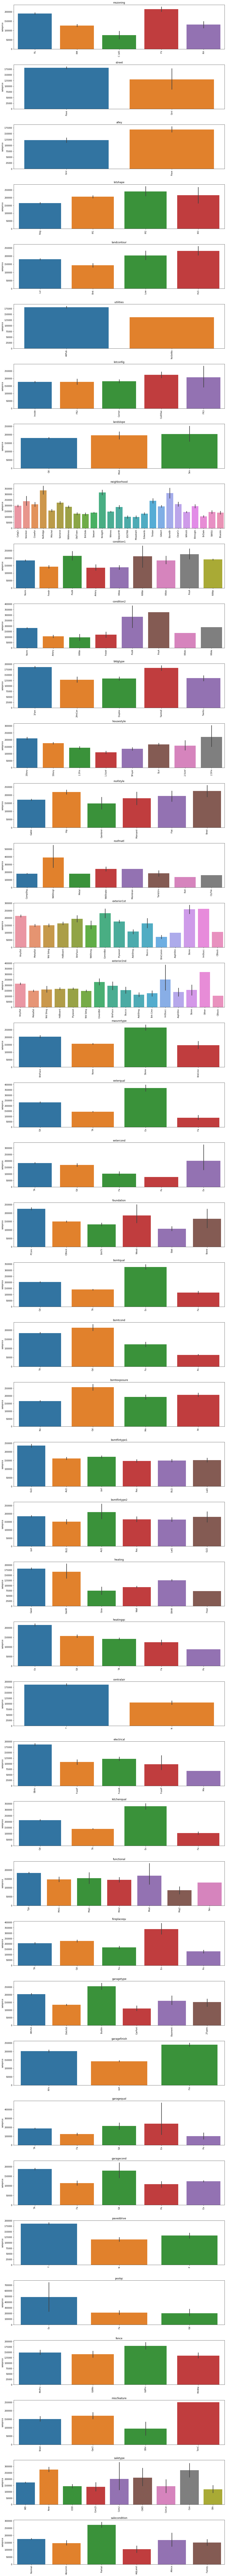

In [15]:
plt.figure(figsize=(15, len(cats)*4))
for i, feature in enumerate(cats):
    plt.subplot(len(cats), 1, i+1)
    sns.barplot(df[feature], df['saleprice'])
    plt.title(feature)
    plt.xlabel('')
    plt.xticks(rotation=90)
plt.tight_layout(pad=0.3)
plt.show()


## Feature Selection and Engineering

For the first pass I select categorical variables with a high variance and continuous variables that are at least moderately correlated.

In [16]:
features = ['saleprice', 'mszoning', 'neighborhood', 'condition1', 'condition2', 'centralair', 'housestyle', 'saletype', 'salecondition', 'overallqual', 'total_square_feet', 'total_full_bath', 'garagearea']

In [17]:
df_features = df[features]

In [18]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   saleprice          1460 non-null   int64 
 1   mszoning           1460 non-null   object
 2   neighborhood       1460 non-null   object
 3   condition1         1460 non-null   object
 4   condition2         1460 non-null   object
 5   centralair         1460 non-null   object
 6   housestyle         1460 non-null   object
 7   saletype           1460 non-null   object
 8   salecondition      1460 non-null   object
 9   overallqual        1460 non-null   int64 
 10  total_square_feet  1460 non-null   int64 
 11  total_full_bath    1460 non-null   int64 
 12  garagearea         1460 non-null   int64 
dtypes: int64(5), object(8)
memory usage: 148.4+ KB


In [19]:
conts = ['overallqual', 'saleprice', 'total_square_feet', 'total_full_bath', 'garagearea']

<Figure size 1440x1440 with 0 Axes>

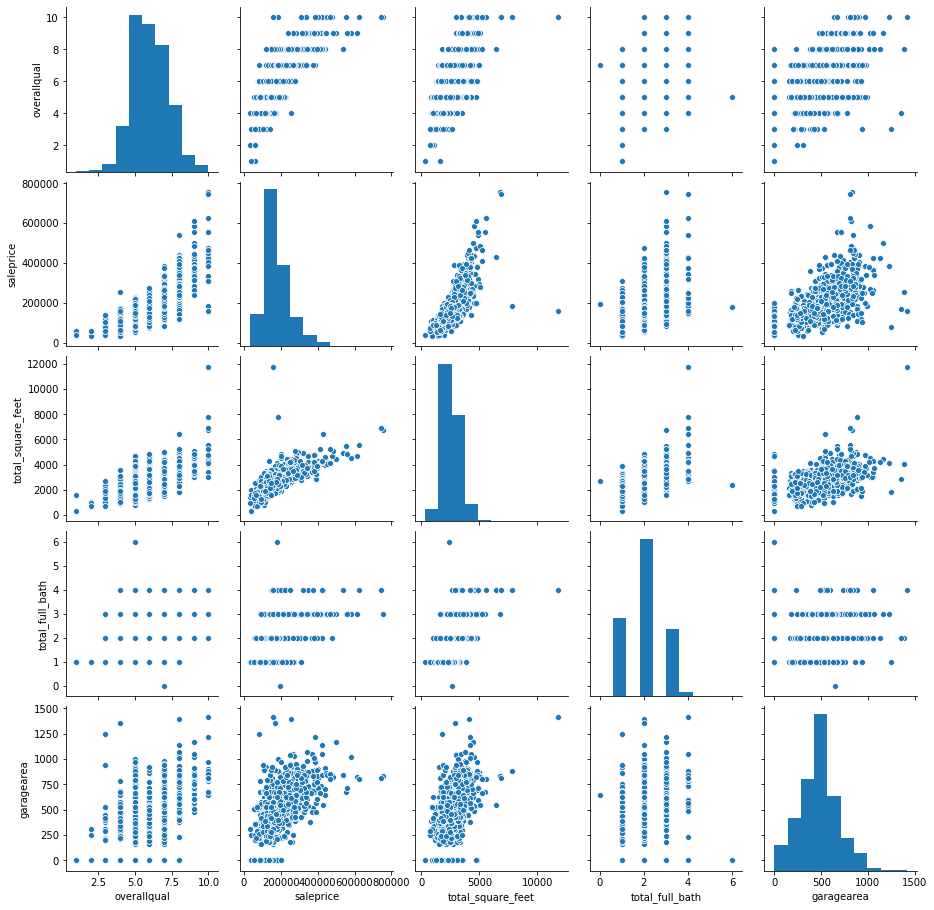

In [20]:
# Take a quick look at the distribution of these variables. Visually we can see that they are all vaguely 
# normally distributed but we will use winzorization and a boxcox transformation to bring them closer to 
# normality

plt.figure(figsize=(20,20))
sns.pairplot(df_features[conts])

In [21]:
print_outliers('inner', df_features)

Continuious Variables 

saleprice
Beyond the inner 95th percentile there are 72 outliers.
Beyond the inner 90th percentile there are 144 outliers.
Beyond the inner 85th percentile there are 220 outliers.
Beyond the inner 80th percentile there are 291 outliers.
Beyond the inner 75th percentile there are 358 outliers.


overallqual
Beyond the inner 95th percentile there are 43 outliers.
Beyond the inner 90th percentile there are 86 outliers.
Beyond the inner 85th percentile there are 86 outliers.
Beyond the inner 80th percentile there are 202 outliers.
Beyond the inner 75th percentile there are 202 outliers.


total_square_feet
Beyond the inner 95th percentile there are 69 outliers.
Beyond the inner 90th percentile there are 145 outliers.
Beyond the inner 85th percentile there are 214 outliers.
Beyond the inner 80th percentile there are 292 outliers.
Beyond the inner 75th percentile there are 366 outliers.


total_full_bath
Beyond the inner 95th percentile there are 20 outliers.
Beyond t

In [22]:
# winsorize the data beyond the inner 95th percentile
for feature in conts:
    df_features.loc[:, feature] = winsorize(df_features.loc[:, feature], (0.05, 0.05))

In [23]:
print_outliers('inner', df_features)

Continuious Variables 

saleprice
Beyond the inner 95th percentile there are 0 outliers.
Beyond the inner 90th percentile there are 0 outliers.
Beyond the inner 85th percentile there are 220 outliers.
Beyond the inner 80th percentile there are 291 outliers.
Beyond the inner 75th percentile there are 358 outliers.


overallqual
Beyond the inner 95th percentile there are 0 outliers.
Beyond the inner 90th percentile there are 0 outliers.
Beyond the inner 85th percentile there are 0 outliers.
Beyond the inner 80th percentile there are 141 outliers.
Beyond the inner 75th percentile there are 141 outliers.


total_square_feet
Beyond the inner 95th percentile there are 0 outliers.
Beyond the inner 90th percentile there are 0 outliers.
Beyond the inner 85th percentile there are 214 outliers.
Beyond the inner 80th percentile there are 292 outliers.
Beyond the inner 75th percentile there are 366 outliers.


total_full_bath
Beyond the inner 95th percentile there are 0 outliers.
Beyond the inner 9

In [24]:
# Create dummy variables for each of the categorical features
cats = df_features.select_dtypes(include='object').columns

for feature in cats:
    df_features = pd.concat([df_features
                             ,pd.get_dummies(df_features[feature], prefix=feature, drop_first=True)]
                           , axis=1)
    df_features.drop(feature, axis=1, inplace=True)

In [25]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 69 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   saleprice              1460 non-null   int64
 1   overallqual            1460 non-null   int64
 2   total_square_feet      1460 non-null   int64
 3   total_full_bath        1460 non-null   int64
 4   garagearea             1460 non-null   int64
 5   mszoning_FV            1460 non-null   uint8
 6   mszoning_RH            1460 non-null   uint8
 7   mszoning_RL            1460 non-null   uint8
 8   mszoning_RM            1460 non-null   uint8
 9   neighborhood_Blueste   1460 non-null   uint8
 10  neighborhood_BrDale    1460 non-null   uint8
 11  neighborhood_BrkSide   1460 non-null   uint8
 12  neighborhood_ClearCr   1460 non-null   uint8
 13  neighborhood_CollgCr   1460 non-null   uint8
 14  neighborhood_Crawfor   1460 non-null   uint8
 15  neighborhood_Edwards   1460 non-null  

In [26]:
for column in conts:
    print(column, '\n', '------------------------------------')
    print('Jarque-Berra test results: {}'.format(jarque_bera(df_features[column])))
    print('Normal Test results: {}'.format(normaltest(df_features[column])))
    print('\n')

overallqual 
 ------------------------------------
Jarque-Berra test results: (63.454065371954286, 1.6653345369377348e-14)
Normal Test results: NormaltestResult(statistic=340.77305378854874, pvalue=1.0047813817843627e-74)


saleprice 
 ------------------------------------
Jarque-Berra test results: (160.04049747423292, 0.0)
Normal Test results: NormaltestResult(statistic=126.7224808087479, pvalue=3.037826217048746e-28)


total_square_feet 
 ------------------------------------
Jarque-Berra test results: (73.04811910599297, 1.1102230246251565e-16)
Normal Test results: NormaltestResult(statistic=113.90042186402152, pvalue=1.8485774416567565e-25)


total_full_bath 
 ------------------------------------
Jarque-Berra test results: (54.17207490561103, 1.7246204464527182e-12)
Normal Test results: NormaltestResult(statistic=237.0821756829857, pvalue=3.2980685003696395e-52)


garagearea 
 ------------------------------------
Jarque-Berra test results: (9.269530013880493, 0.009708388174155869)
N

In [27]:
# check model performance before transformation

X = df_features.drop('saleprice', axis=1)
y = df_features['saleprice']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.02, random_state=1312)

In [28]:
results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              saleprice   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                              1361.
Date:                Mon, 07 Sep 2020   Prob (F-statistic):                        0.00
Time:                        12:30:06   Log-Likelihood:                         -16377.
No. Observations:                1430   AIC:                                  3.289e+04
Df Residuals:                    1362   BIC:                                  3.325e+04
Df Model:                          68                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
overallqual             1.27e+04    892.627     14.226      0.000    1.09e+04    1.44e+04
total_square_feet        38.4588      1.578     24.371      0.000      35.363      41.554
total_full_bath        6433.0836   1219.368      5.276      0.000    4041.040    8825.128
garagearea               34.7798      4.332      8.028      0.000      26.281      43.279
mszoning_FV           -1.867e+04   1.05e+04     -1.785      0.074   -3.92e+04    1842.745
mszoning_RH           -1.691e+04   1.04e+04     -1.624      0.105   -3.73e+04    3518.606
mszoning_RL           -1.002e+04   8449.954     -1.186      0.236   -2.66e+04    6553.685
mszoning_RM           -1.693e+04   8257.388     -2.050      0.041   -3.31e+04    -728.177
neighborhood_Blueste  -1.234e+04   1.78e+04     -0.695      0.487   -4.72e+04    2.25e+04
neighborhood_BrDale   -2.013e+04   8661.168     -2.324      0.020   -3.71e+04   -3136.193
neighborhood_BrkSide  -2052.5274   6663.798     -0.308      0.758   -1.51e+04     1.1e+04
neighborhood_ClearCr   1.984e+04   7280.164      2.725      0.007    5559.259    3.41e+04
neighborhood_CollgCr   2880.4955   5864.313      0.491      0.623   -8623.570    1.44e+04
neighborhood_Crawfor   1.984e+04   6533.047      3.037      0.002    7022.187    3.27e+04
neighborhood_Edwards  -1.086e+04   6157.462     -1.763      0.078   -2.29e+04    1223.493
neighborhood_Gilbert   4728.3409   6272.724      0.754      0.451   -7576.908     1.7e+04
neighborhood_IDOTRR   -8898.1621   7342.288     -1.212      0.226   -2.33e+04    5505.258
neighborhood_MeadowV  -1.471e+04   8702.652     -1.691      0.091   -3.18e+04    2359.019
neighborhood_Mitchel  -8717.7605   6537.384     -1.334      0.183   -2.15e+04    4106.672
neighborhood_NAmes    -9260.0815   5865.928     -1.579      0.115   -2.08e+04    2247.151
neighborhood_NPkVill  -1.994e+04   9626.089     -2.072      0.038   -3.88e+04   -1056.984
neighborhood_NWAmes   -7082.4976   6334.222     -1.118      0.264   -1.95e+04    5343.391
neighborhood_NoRidge   3.716e+04   6882.256      5.399      0.000    2.37e+04    5.07e+04
neighborhood_NridgHt   3.377e+04   6229.320      5.421      0.000    2.15e+04     4.6e+04
neighborhood_OldTown  -1.321e+04   6444.667     -2.050      0.041   -2.59e+04    -572.172
neighborhood_SWISU    -1.877e+04   7804.969     -2.404      0.016   -3.41e+04   -3453.977
neighborhood_Sawyer   -4710.8576   6364.265     -0.740      0.459   -1.72e+04    7773.967
neighborhood_SawyerW   3222.8683   6507.045      0.495      0.620   -9542.050     1.6e+04
neighborhood_Somerst   1.677e+04   7739.458      2.166      0.030    1583.088    3.19e+04
neighborhood_StoneBr   2.848e+04   7345.707      3.877      0.000    1.41e+04    4.29e+04
neighborhood_T

Weak features include: mszoning, salecondition.

In [72]:
log_saleprice = np.log(df['saleprice'])

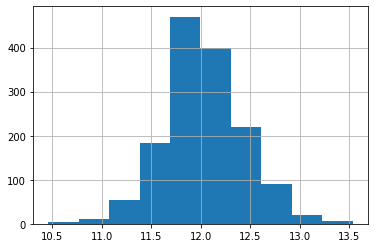

In [73]:
log_saleprice.hist()

In [74]:
jarque_bera(log_saleprice)

(42.7672735832514, 5.166596039885007e-10)

In [85]:
stats.describe(log_saleprice)

DescribeResult(nobs=1460, minmax=(10.460242108190519, 13.534473028231162), mean=12.024050901109383, variance=0.15956179505733456, skewness=0.1212103673013655, kurtosis=0.8026555069117705)

(array([  5.,  12.,  54., 184., 470., 400., 220.,  90.,  19.,   6.]),
 array([10.46024211, 10.7676652 , 11.07508829, 11.38251138, 11.68993448,
        11.99735757, 12.30478066, 12.61220375, 12.91962684, 13.22704994,
        13.53447303]),
 <a list of 10 Patch objects>)

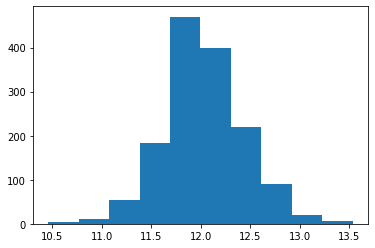

In [80]:
plt.hist(log_saleprice[mask[0]])

In [91]:
for feature in cats:
    print(df[feature].value_counts())

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: mszoning, dtype: int64
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: neighborhood, dtype: int64
Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: condition1, dtype: int64
Norm      1445
Feedr        6
PosN         2
Artery       2
RRNn         2
PosA         1
RRAn         1
RRAe         1
Name: condition2, dtype: int64
Y    1365
N      95
Name: centralair, dtype: int64
1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Nam

(array([ 62., 774., 524.,  87.,   8.,   3.,   1.,   0.,   0.,   1.]),
 array([  334. ,  1475.8,  2617.6,  3759.4,  4901.2,  6043. ,  7184.8,
         8326.6,  9468.4, 10610.2, 11752. ]),
 <a list of 10 Patch objects>)

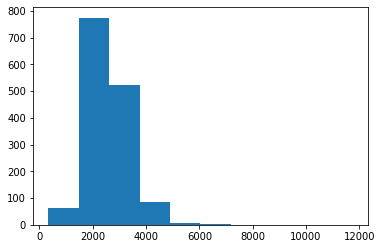